In [5]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

In [6]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE, SimpleForwardNetBN
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathcal{N}(y | \theta^\top x_i + \theta_0, \sigma_y^2 \mathbb{I})
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$.

## Loading the StepFunc dataset

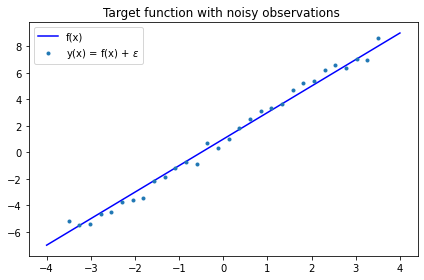

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

func = lambda x: 2* x + 1

# Test inputs
num_test_samples = 30
X_test = np.linspace(-4, 4, num_test_samples).reshape(num_test_samples,1)

# Noise free training inputs
X_train = np.linspace(-3.5, 3.5, 30).reshape(-1,1)
#f_train = np.cos(X_train) 
f_train = func(X_train)

# Noise-free training outputs
#f = np.cos(X_test)
f = func(X_test)
y_test  = f

# Noisy training Inputs with additive Gaussian noise (zero-mean, variance sigma_n)
sigma_n = 0.5

mu = np.zeros(X_train.size)
epsilon = np.random.multivariate_normal(mu, sigma_n**2 * np.eye(X_train.size))

# Noisy targets
y_train = f_train + epsilon.reshape(X_train.size,1)

# Noisy observations
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
ax.plot(X_test, f, 'b', label = 'f(x)')
ax.plot(X_train, y_train,".",  label = 'y(x) = f(x) + $\epsilon$')
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

In [8]:
X_train.shape, f_train.shape

((30, 1), (30, 1))

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"



X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}


In [10]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        self.shapes = []
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq and self.depth > -1:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
            
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes]) if self.depth > -1 else self.input_dim + 1
        
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape

#         Θ = (Θ - Θ.mean()) / Θ.std()

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
#         import pdb; pdb.set_trace()
        wx, wy = self.shapes[-1] if self.shapes else (self.input_dim, self.output_dim)
#         import pdb; pdb.set_trace()
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx),
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [11]:
net = OnedRegressionForwardNet(
    1,1, device=device, depth=-1, width=1, activation=F.relu
)

def ln_prior(Θ, σ_w=1.5):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w**2 


def log_likelihood_vmap(Θ, X, y, net=net, σ_y=0.5):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    preds_func = lambda θ: net.forward(X, θ)
#     batched_preds = torch._vmap_internals.vmap(preds_func)
#     import pdb; pdb.set_trace()
    preds = torch.hstack(list(map(preds_func, Θ)))

    diff = preds - y
#     import pdb; pdb.set_trace()
    diff_sq_fld = -0.5 * (diff**2).sum(dim=0) / σ_y**2

    return diff_sq_fld

In [12]:

γ = 0.5
Δt = 0.01

sde, losses = basic_batched_trainer(
    γ, Δt, ln_prior, log_likelihood_vmap, net.dim, X_train, y_train=y_train,
    method="euler", stl=True, adjoint=False, optimizer=None,
    num_steps=200, batch_size_data=None, batch_size_Θ=50,
    batchnorm=True, device=device
)

  0%|          | 0/200 [00:00<?, ?it/s]

c:\users\vargf\onedrive\documents\projects\controlledfollmerdrift\cfollmer\objectives.py:97: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f = _vmap_internals.vmap(f_)
c:\users\vargf\onedrive\documents\projects\controlledfollmerdrift\cfollmer\objectives.py:98: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  f_detached = _vmap_internals.vmap(sde.f_detached)


In [13]:
torch.cuda.empty_cache()

In [14]:
losses

[1251.8585205078125,
 1112.008544921875,
 1216.330810546875,
 1091.48486328125,
 1182.518310546875,
 1262.8883056640625,
 1333.3272705078125,
 1192.234619140625,
 1116.92041015625,
 1172.080810546875,
 1417.9197998046875,
 1188.0662841796875,
 1145.496337890625,
 1181.2554931640625,
 1180.3336181640625,
 1116.469482421875,
 1139.7767333984375,
 1255.1324462890625,
 1092.9298095703125,
 1255.660888671875,
 1207.16943359375,
 1215.0147705078125,
 1220.0958251953125,
 1176.8958740234375,
 1218.1182861328125,
 1299.329833984375,
 1149.2818603515625,
 1168.023193359375,
 1108.4578857421875,
 1122.0372314453125,
 1092.7332763671875,
 1103.5916748046875,
 1119.298828125,
 1022.4739379882812,
 1074.342041015625,
 996.6860961914062,
 973.8862915039062,
 895.8507080078125,
 918.5262451171875,
 1089.5313720703125,
 1000.6162109375,
 1062.047119140625,
 962.0982666015625,
 874.1393432617188,
 952.4588623046875,
 912.5187377929688,
 899.93896484375,
 841.778076171875,
 896.8395385742188,
 772.40039

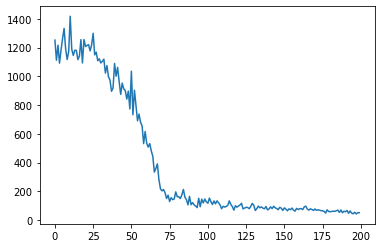

In [15]:
plt.plot(losses[:])

In [17]:
Θ_0 = torch.zeros((100, net.dim)).to(device) 
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)

torch.cuda.empty_cache()


Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 3.,  4., 11., 25., 22., 20.,  7.,  7.,  0.,  1.]),
 array([-0.41126436, -0.08608074,  0.23910289,  0.56428653,  0.88947016,
         1.2146537 ,  1.5398374 ,  1.865021  ,  2.1902046 ,  2.5153883 ,
         2.8405719 ], dtype=float32),
 <a list of 10 Patch objects>)

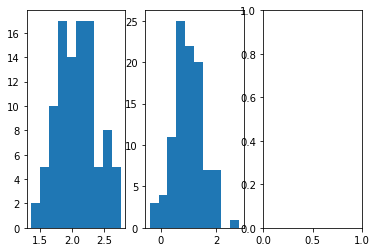

In [18]:
torch.cuda.empty_cache()
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
# ax3.hist(Θ_1[:,-23].cpu().detach().numpy())

In [19]:
# pred = net.map_forward(X_train, Θ_1.mean(dim=0).reshape(1,-1))#.mean(axis=1)
end = 6.5
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

pred_ = net.map_forward(X_train_2, Θ_1)
pred = pred_.mean(axis=1)

σ  = pred_.std(axis=1)

C:\Users\vargf\AppData\Local\Temp/ipykernel_39904/4055719056.py:57: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_preds = torch._vmap_internals.vmap(preds_func)


In [20]:
σ.shape, pred.shape

(torch.Size([100]), torch.Size([100]))

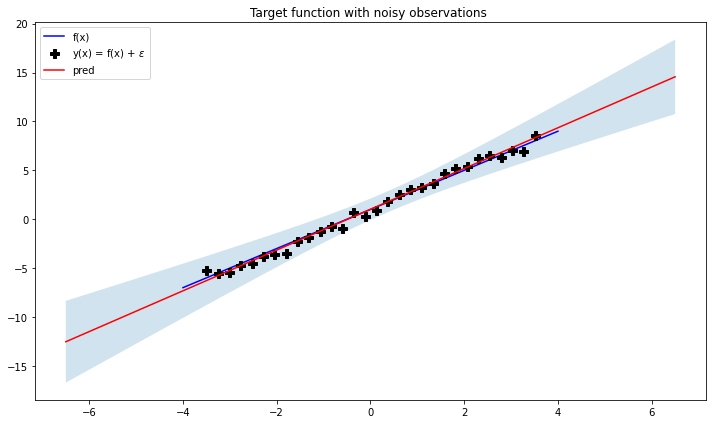

In [21]:
fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)
ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
ax.plot(X_train_2.detach().cpu(), pred.detach().cpu(), color="red", label="pred")

σ_p , σ_m = (pred-2*σ).detach().cpu().numpy(), (pred+2*σ).detach().cpu().numpy()
ax.fill_between(X_train_2.detach().cpu().flatten(), σ_p.flatten() , σ_m.flatten(), alpha=.2)
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

plt.show()

Text(0.5, 1.0, 'Sampled Posterior Weights')

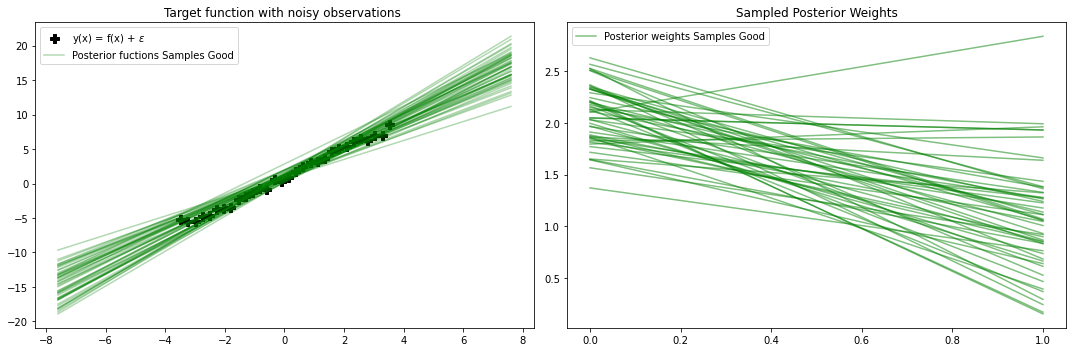

In [22]:

fig, (ax, ax1) = plt.subplots(1,2, figsize=(15, 5), tight_layout=True)
# ax.plot(X_test.detach().cpu(), f, 'b', label = 'f(x)')
ax.plot(X_train.detach().cpu(), y_train.detach().cpu(), 'kP', ms = 9, label = 'y(x) = f(x) + $\epsilon$')
# ax.plot(X_train.detach().cpu(), pred.detach().cpu(), color="red", label="pred")


zero_ind = torch.abs(X_train).argmin()

thresh = 10
label_2, label_1 = True, True

end=7.6
X_train_2 = torch.linspace(-end, end, 100).reshape(-1,1).to(device)

for i in range(50):
#     print(Θ_1[i,:3])
    θ = Θ_1[i,:,]
    pred = net.forward(X_train_2, θ).mean(axis=1)
    pred_min, pred_max = pred[zero_ind-thresh], pred[zero_ind+thresh]
    label = True if i==0 else False
    if torch.abs(pred_min - pred_max) < 0.25:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="red", label="Posterior function Samples Flat" if label_1 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="red", label="Posterior weights Samples Flat"  if label_1 else None)
        label_1 = False
    else:
        ax.plot(
            X_train_2.detach().cpu(), pred.detach().cpu(),
            alpha=0.3, color="green", label="Posterior fuctions Samples Good" if label_2 else None
        )
        ax1.plot(θ.detach().cpu(),  alpha=0.5, color="green", label="Posterior weights Samples Good" if label_2 else None )
        label_2 = False 
        
        
ax.legend(loc = 'upper left')
ax.set_title('Target function with noisy observations ')

ax1.legend(loc = 'upper left')
ax1.set_title('Sampled Posterior Weights')
# plt.plot(X_train.detach().cpu(), y_train.detach().cpu())

